In [1]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   
import seaborn as sns


# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [2]:
bucket_name = 'ccfinals3' 
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


# Data Preprocessing

### Loading Data

In [3]:
bucket = 'ccfinals3/'
prefix = 'Data/'

df = pd.read_csv('s3://' + bucket + prefix + 'framingham.csv')

In [4]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [5]:
# Print the dimension of df
pd.DataFrame([[df.shape[0], df.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,4240,16


In [6]:
df.dtypes

male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

In [7]:
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4240.000000,4240.000000,4135.000000,4240.000000,4211.000000,4187.000000,4240.000000,4240.000000,4240.000000,4190.000000,4240.000000,4240.000000,4221.000000,4239.000000,3852.000000,4240.000000
mean,0.429245,49.580189,1.979444,0.494104,9.005937,0.029615,0.005896,0.310613,0.025708,236.699523,132.354599,82.897759,25.800801,75.878981,81.963655,0.151887
std,0.495027,8.572942,1.019791,0.500024,11.922462,0.169544,0.076569,0.462799,0.158280,44.591284,22.033300,11.910394,4.079840,12.025348,23.954335,0.358953
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,90.000000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


### Identifying the identifiers

In [8]:
def id_checker(df):
    """
    The identifier checker

    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    The dataframe of identifiers
    """
    
    # Get the identifiers
    df_id = df[[var for var in df.columns 
                if df[var].nunique(dropna=True) == df[var].notnull().sum()]]
                
    return df_id

In [9]:
# Call id_checker on df
df_id = id_checker(df)

# Print the first 5 rows of df_id
df_id.head()

""
0
1
2
3
4


### Identifying missing values


In [10]:
def nan_checker(df):
    """
    The NaN checker

    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    The dataframe of variables with NaN, their percentage of NaN and dtype
    """
    
    # Get the dataframe of variables with NaN, their percentage of NaN and dtype
    df_nan = pd.DataFrame([[var, df[var].isnull().sum()*100/len(df[var]), df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'percentage', 'dtype'])
    
    # Sort df_nan in accending order of the percentage of NaN
    df_nan = df_nan.sort_values(by='percentage', ascending=False).reset_index(drop=True)
    
    return df_nan

In [11]:
# Call nan_checker on df
df_nan = nan_checker(df)

# Get the variables with missing values, their percentage of missing values and dtype
df_miss = df_nan[df_nan['dtype'] == 'float64'].reset_index(drop=True)

# Print df_miss
df_miss

,var,percentage,dtype
0,glucose,9.150943,float64
1,education,2.476415,float64
2,BPMeds,1.250000,float64
3,totChol,1.179245,float64
4,cigsPerDay,0.683962,float64
5,BMI,0.448113,float64
6,heartRate,0.023585,float64


In [18]:
count=0
for i in df.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values is', count)
print('This is',round((count/len(df.index))*100),'% of the entire dataset so we will exclude the rows with missing values')

Total number of rows with missing values is 582
This is 14 % of the entire dataset so we will exclude the rows with missing values


In [109]:
# Remove rows with missing values from df
df = df.dropna(subset=np.intersect1d(df_miss['var'], df.columns),
                           inplace=False)

# Print the dimension of df
pd.DataFrame([[df.shape[0], df.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,3658,16


## Exploratory Data Analysis (EDA)

### Patient Demographics

In [112]:
print('The oldest patient: {} years.'.format(df["age"].max()))
print('The youngest patient: {} years.'.format(df["age"].min()))
print('Average age: {} years.'.format(df['age'].mean()))
print('Median age: {} years.'.format(df['age'].median(skipna=True)))

The oldest patient: 70 years.
The youngest patient: 32 years.
Average age: 49.55194095133953 years.
Median age: 49.0 years.


## Feature Selection

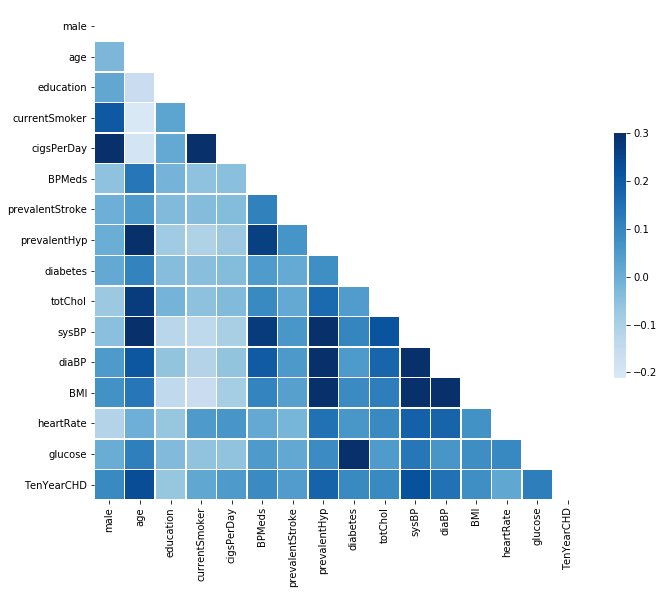

In [155]:
# Compute the correlation matrix
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap="Blues", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [143]:
# Identify the features with the most importance for the outcome variable Heart Disease

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# separate independent & dependent variables
x=df.drop('TenYearCHD', axis=1) #feature columns
y=df.TenYearCHD #target column i.e TenYearCHD

# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Importance']  #naming the dataframe columns
featureScores = featureScores.sort_values(ascending=False, by='Importance') 
featureScores #print 10 best features

,Features,Importance
10,sysBP,669.136021
14,glucose,379.914235
1,age,296.200344
9,totChol,250.490205
4,cigsPerDay,155.798307
11,diaBP,142.521814
7,prevalentHyp,82.845455
8,diabetes,31.067621
5,BPMeds,28.191569
0,male,17.107751


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

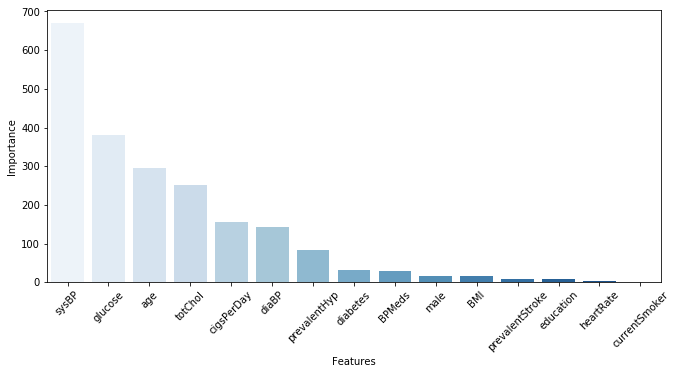

In [152]:
# Create a figure
fig = plt.figure(figsize=(11, 5))


# The bar plot of feature importance
sns.barplot(featureScores['Features'], featureScores['Importance'], palette = "Blues")

# Set x-axis
plt.xlabel('Features')

# Set y-axis
plt.ylabel('Importance')

plt.xticks(rotation=45)


In [70]:
df_id.shape

(4240, 16)

In [54]:
# Seperate feature variables from target variables
x=df.drop('TenYearCHD', axis=1) #feature columns
y=df.TenYearCHD #target column i.e TenYearCHD

In [55]:
x.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0


In [60]:
x.shape

(4240, 15)

In [61]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [62]:
# Print the dimension of x_train
pd.DataFrame([[x_train.shape[0], x_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,3392,15


In [63]:
# Print the dimension of x_test
pd.DataFrame([[x_test.shape[0], x_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,848,15


In [35]:
# Print the first 5 rows of x_train
x_train.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
4227,1,43,4.0,1,20.0,0.0,0,0,0,187.0,129.5,88.0,25.62,80.0,75.0
1811,1,43,1.0,1,20.0,0.0,0,0,0,180.0,131.0,92.0,27.18,65.0,85.0
3301,0,40,2.0,1,20.0,0.0,0,0,0,165.0,101.0,59.0,23.06,60.0,76.0
1203,1,64,1.0,1,30.0,0.0,0,1,0,253.0,178.0,106.0,24.68,100.0,76.0
2615,0,47,1.0,1,9.0,0.0,0,0,0,214.0,118.0,72.0,24.08,60.0,NaN


In [36]:
# Print the first 5 rows of x_test
x_test.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
1465,0,47,1.0,1,20.0,0.0,0,1,0,325.0,160.0,95.0,32.07,95.0,87.0
302,0,55,1.0,0,0.0,0.0,0,0,0,220.0,117.5,84.0,26.20,90.0,NaN
87,0,61,2.0,1,1.0,0.0,0,1,0,326.0,200.0,104.0,38.46,57.0,78.0
843,0,46,2.0,0,0.0,0.0,0,0,0,225.0,116.0,79.0,29.21,60.0,70.0
1431,1,39,1.0,0,0.0,0.0,0,0,0,213.0,130.0,72.0,22.32,80.0,78.0


In [33]:
y_train.shape

(3392,)

In [34]:
y_test.shape

(848,)